Importing the libraries

In [60]:
# !pip install tensorflow==2.3.0
# !pip install keras==2.4.3
# !pip install pydot==1.4.2

# !pip install -q -U tensorflow-addons==0.13.0
# !pip install tensorflow_datasets
# !pip install ipywidgets

# !pip install jupyter
# !jupyter nbextension enable --py widgetsnbextension

import os
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import utils

Loading the MNIST Dataset

In [61]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Creating the Distance Layer for the Model

In [62]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

Defining the embedding model architecture

In [63]:
def create_siamese_twin():
    """
    creates and returns an embedding model to be used in the siamese architecture
    """
    # Define the tensors for the two input images
    input_twin = Input(IMAGE_SHAPE)
    x = layers.Conv2D(512, (2, 2), activation="relu")(input_twin)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (2, 2), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (1, 1), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(64, name="final_dense", activation=None)(x)
    return Model(input_twin, outputs)

Putting the whole network together

In [64]:
def create_siamese_network():
    """
    creates and returns the final siamese architecture with the embedded model
    """
    middle_input = Input(IMAGE_SHAPE)
    left_input = Input(IMAGE_SHAPE)
    right_input = Input(IMAGE_SHAPE)
    twin = create_siamese_twin()
    
    distances = DistanceLayer()(twin(middle_input), twin(left_input), twin(right_input))
    
    model = Model(inputs=[middle_input, left_input, right_input], outputs=distances)
    return model

Defining the custom training loops

In [92]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        # self.accuracy = SiameseNetworkAccuracy

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        # self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}  # add accuracy

    def test_step(self, data):
        
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

def accuracy(y_true, y_pred):
    """
    returns the keras binary accuracy
    """
    return metrics.binary_accuracy(y_true, 1 - y_pred)

In [79]:
# The image shape to be fed in the model
IMAGE_SHAPE = x_train.shape[1:]
print('IMAGE_SHAPE', IMAGE_SHAPE)

IMAGE_SHAPE (28, 28, 1)


Triplet Generation

In [80]:
def shuffle_triplets(triplets):
    """
    returns the shuffled array of the triplets
    """
    triplets_len = list(range(len(triplets[0])))
    np.random.shuffle(triplets_len)
    triplets_shuffles = [triplets[0][triplets_len], triplets[1][triplets_len], triplets[2][triplets_len]]
    return triplets_shuffles

def create_triplets(images_set, label_set, num_pos, num_neg, test = False, validation_split = 0.7):
    """
    creates and splits all possible triplets for training and validation
    """
    left_images = []
    middle_images = []
    right_images = []
    
    set_labels = []
    
    for label in set(label_set):
        label_pos_ids = np.where(label_set == label)[0]
        label_neg_ids = np.where(label_set != label)[0]
        np.random.shuffle(label_pos_ids)
        np.random.shuffle(label_neg_ids)
        
        positive_examples = label_pos_ids[:num_pos]
        negative_examples = label_neg_ids[:num_neg]
        triplet_labels = list(itertools.product(positive_examples, positive_examples, negative_examples))

        for trp in triplet_labels:
            left_images.append(images_set[trp[0]])
            middle_images.append(images_set[trp[1]])
            right_images.append(images_set[trp[2]])
            set_labels.append(1.0)
    
    triplets, labels = [np.array(left_images), np.array(middle_images), np.array(right_images)], np.array(set_labels)
    triplets = shuffle_triplets(triplets)
    
    if test:
        return (triplets, labels)

    split_point = int(num_pos * num_pos * num_neg * len(set(label_set)) * 0.7)
    train_triplets, train_labels = [triplets[0][:split_point], triplets[1][:split_point], triplets[2][:split_point]], labels[:split_point]
    val_triplets, val_labels = [triplets[0][split_point:], triplets[1][split_point:], triplets[2][split_point:]], labels[split_point:]
    
    return (train_triplets, train_labels), (val_triplets, val_labels)  

In [81]:
TRAIN_NUM_POS = 4 # Number of positive examples to consider per class
TRAIN_NUM_NEG = 9 # Number of negative examples to consider per class

TEST_NUM_POS = 3 # Number of positive examples to consider per class
TEST_NUM_NEG = 6 # Number of negative examples to consider per class

In [82]:
# Storing the triplets
(train_triplets, train_labels), (val_triplets, val_labels)  = create_triplets(x_train, y_train, TRAIN_NUM_POS, TRAIN_NUM_NEG)
(test_triplets, test_labels) = create_triplets(x_test, y_test, TEST_NUM_POS, TEST_NUM_NEG, test= True)

In [83]:
# Checking the shapes for the triplets
print("Train Triplets Shape: {}, Train Labels Shape: {}".format(np.array(train_triplets).shape, train_labels.shape))
print("Val Triplets Shape: {}, Val Labels Shape: {}".format(np.array(val_triplets).shape, val_labels.shape))
print("Test Triplets Shape: {}, Test Labels Shape: {}".format(np.array(test_triplets).shape, test_labels.shape))

Train Triplets Shape: (3, 1007, 28, 28, 1), Train Labels Shape: (1007,)
Val Triplets Shape: (3, 433, 28, 28, 1), Val Labels Shape: (433,)
Test Triplets Shape: (3, 540, 28, 28, 1), Test Labels Shape: (540,)


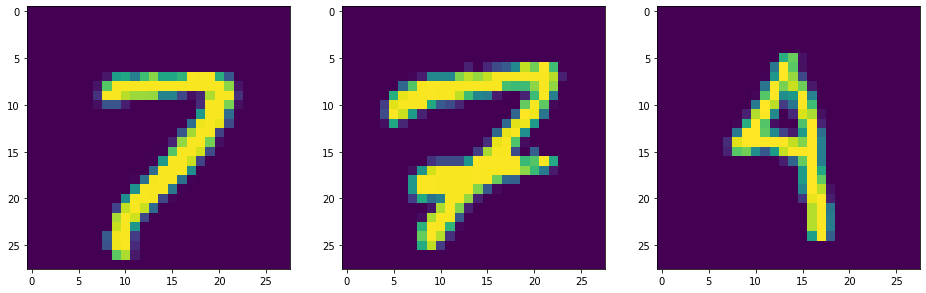

In [84]:
# plotting some triplets 
%matplotlib inline
num = np.random.randint(0, len(train_labels))
plt.figure(figsize= (16,15))
plt.subplot(1,3,1)
plt.imshow(train_triplets[0][num])
plt.subplot(1,3,2)
plt.imshow(train_triplets[1][num])
plt.subplot(1,3,3)
plt.imshow(train_triplets[2][num])

Creating the model

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_13 (Functional)      (None, 64)           633792      input_13[0][0]                   
                                                                 input_14[0][0]       

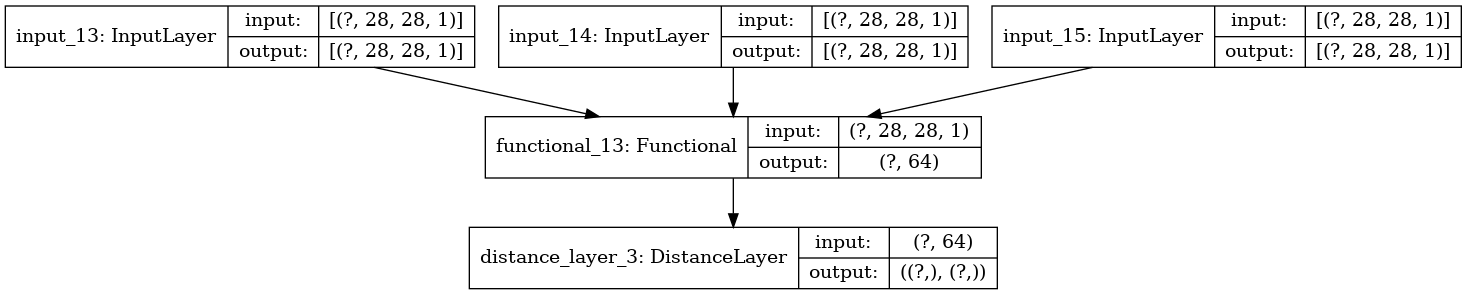

In [85]:
siamese_network = create_siamese_network()
siamese_network.summary()
tf.keras.utils.plot_model(siamese_network, show_shapes = True)

Compiling the Model

In [90]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), metrics=accuracy)

Training the model

In [91]:
siamese_model.fit((train_triplets, train_labels), validation_data= ((val_triplets, val_labels)), epochs = 5)

Epoch 1/5
32/32 [==============================] - 17s 528ms/step - loss: 6.9149e-05 - val_loss: 8.6102e-04
Epoch 2/5
32/32 [==============================] - 16s 500ms/step - loss: 3.7628e-04 - val_loss: 1.6824e-04
Epoch 3/5
32/32 [==============================] - 18s 549ms/step - loss: 2.2823e-05 - val_loss: 6.2524e-04
Epoch 4/5
32/32 [==============================] - 17s 527ms/step - loss: 0.0000e+00 - val_loss: 7.1156e-04
Epoch 5/5
32/32 [==============================] - 16s 514ms/step - loss: 0.0000e+00 - val_loss: 7.1493e-04


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f9d7a30a-760e-4df9-995d-bfc22963224f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>